# Modelos kNN para el mercado inmobiliario

En el presente notebook investigamos distintos tipos de modelos kNN para predecir los valores de las propiedades en el mercado inmobiliario de Buenos Aires. El modelo kNN, por su naturaleza, captura la intuición habitual con respecto a la determinación de los precios de las propiedades: que lo más determinante es la zona en la que se encuentran. Asimismo, pareciera ser el modelo que utiliza [Properati](https://www.properati.com.ar/data/) (de donde fueron extraídos los datos del presente notebook) para su [preciómetro](https://www.properati.com.ar/tools/valuador-propiedades).

In [1]:
import os
# import warnings
# warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
os.chdir('..')
df = pd.read_csv('Data/Properati_data_clean.csv')
os.chdir('Notebooks')
df.head()

,created_on,lat,lon,barrio_publicado,rooms,surface_total,surface_covered,price,title,description,property_type,barrio,surface_uncovered,price_m2
0,2019-08-04,-34.601864,-58.443563,Villa Crespo,3.0,67.0,60.0,110000.0,Departamento venta,Warnes al 500 – Villa Crespo – CABA. \r\nAmpli...,Departamento,VILLA CRESPO,7.0,1732.283465
1,2019-08-04,-34.644735,-58.421061,Boedo,2.0,40.0,40.0,79900.0,Departamento - Boedo - 2 amb MUY LUMINOSO!! ...,"GRAN OPORTUNIDAD, SE BAJO DE PRECIO!! IDEAL I...",Departamento,NUEVA POMPEYA,0.0,1997.500000
2,2019-08-04,-34.603423,-58.431140,Almagro,2.0,38.0,38.0,112000.0,Dos Ambientes Reciclado a 1 cuadra del Subte B,"Dos Ambientes Reciclado, primer piso contrafre...",Departamento,ALMAGRO,0.0,2947.368421
3,2019-08-04,-34.609326,-58.492374,Villa del Parque,2.0,94.0,77.0,169000.0,PH DE 3 PLANTAS CON COCHERA PROPIA Y TERRAZA,Hermoso e impecable triplex con vista verde ha...,PH,VILLA DEL PARQUE,17.0,1976.608187
4,2019-05-27,-34.629607,-58.439279,NaN,1.0,41.0,37.0,118000.0,Departamento venta,"Increible departamento 41 m2, mono ambiente en...",Departamento,PARQUE CHACABUCO,4.0,3025.641026


In [3]:
# Elimino las columnas que no voy a usar
df.drop(columns=['created_on','barrio_publicado','title','description'],inplace=True)

### Encoding de variables categóricas

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
property_coded = le.fit_transform(df['property_type'])
list(le.classes_)

['Casa', 'Departamento', 'PH']

In [5]:
ohe = OneHotEncoder(sparse=False, categories='auto')
# Transformo la fila en columna
property_coded = property_coded.reshape(len(property_coded), 1)
# Creo el encoder
ohe = ohe.fit_transform(property_coded)
categoricals_df = pd.DataFrame({'Casa': ohe[:, 0], 'Departamento': ohe[:, 1],'PH': ohe[:, 2]})
# Junto los df
categoricals_df = categoricals_df.set_index(df.index)
df = pd.concat([df, categoricals_df], axis=1)
# A ver...
df

,lat,lon,rooms,surface_total,surface_covered,price,property_type,barrio,surface_uncovered,price_m2,Casa,Departamento,PH
0,-34.601864,-58.443563,3.0,67.0,60.0,110000.0,Departamento,VILLA CRESPO,7.0,1732.283465,0.0,1.0,0.0
1,-34.644735,-58.421061,2.0,40.0,40.0,79900.0,Departamento,NUEVA POMPEYA,0.0,1997.500000,0.0,1.0,0.0
2,-34.603423,-58.431140,2.0,38.0,38.0,112000.0,Departamento,ALMAGRO,0.0,2947.368421,0.0,1.0,0.0
3,-34.609326,-58.492374,2.0,94.0,77.0,169000.0,PH,VILLA DEL PARQUE,17.0,1976.608187,0.0,0.0,1.0
4,-34.629607,-58.439279,1.0,41.0,37.0,118000.0,Departamento,PARQUE CHACABUCO,4.0,3025.641026,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27015,-34.580718,-58.440610,4.0,82.0,77.0,250000.0,Departamento,PALERMO,5.0,3144.654088,0.0,1.0,0.0
27016,-34.578688,-58.435533,2.0,80.0,80.0,170000.0,Departamento,PALERMO,0.0,2125.000000,0.0,1.0,0.0
27017,-34.581425,-58.442707,3.0,88.0,82.0,399000.0,Departamento,PALERMO,6.0,4694.117647,0.0,1.0,0.0
27018,-34.576573,-58.434394,3.0,84.0,84.0,178000.0,PH,PALERMO,0.0,2119.047619,0.0,0.0,1.0


In [6]:
# Hacemos lo mismo para los barrios
le_barrios = LabelEncoder()
barrios_coded = le_barrios.fit_transform(df['barrio'])
barrios_list = list(le_barrios.classes_)
barrios_list[:7]

['AGRONOMIA', 'ALMAGRO', 'BALVANERA', 'BARRACAS', 'BELGRANO', 'BOCA', 'BOEDO']

In [7]:
ohe_barrios = OneHotEncoder(sparse=False, categories='auto')
# Transformo la fila en columna
barrios_coded = barrios_coded.reshape(len(barrios_coded), 1)
# Creo el encoder
ohe_barrios = ohe_barrios.fit_transform(barrios_coded)
barrios_dict = {barrios_list[i]:ohe_barrios[:,i] for i in range(len(barrios_list))}
barrios_df = pd.DataFrame(barrios_dict)
# Junto los df
barrios_df = barrios_df.set_index(df.index)
df = pd.concat([df, barrios_df], axis=1)
# A ver...
df

,lat,lon,rooms,surface_total,surface_covered,price,property_type,barrio,surface_uncovered,price_m2,...,VILLA GRAL. MITRE,VILLA LUGANO,VILLA LURO,VILLA ORTUZAR,VILLA PUEYRREDON,VILLA REAL,VILLA RIACHUELO,VILLA SANTA RITA,VILLA SOLDATI,VILLA URQUIZA
0,-34.601864,-58.443563,3.0,67.0,60.0,110000.0,Departamento,VILLA CRESPO,7.0,1732.283465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-34.644735,-58.421061,2.0,40.0,40.0,79900.0,Departamento,NUEVA POMPEYA,0.0,1997.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-34.603423,-58.431140,2.0,38.0,38.0,112000.0,Departamento,ALMAGRO,0.0,2947.368421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-34.609326,-58.492374,2.0,94.0,77.0,169000.0,PH,VILLA DEL PARQUE,17.0,1976.608187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-34.629607,-58.439279,1.0,41.0,37.0,118000.0,Departamento,PARQUE CHACABUCO,4.0,3025.641026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27015,-34.580718,-58.440610,4.0,82.0,77.0,250000.0,Departamento,PALERMO,5.0,3144.654088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27016,-34.578688,-58.435533,2.0,80.0,80.0,170000.0,Departamento,PALERMO,0.0,2125.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27017,-34.581425,-58.442707,3.0,88.0,82.0,399000.0,Departamento,PALERMO,6.0,4694.117647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27018,-34.576573,-58.434394,3.0,84.0,84.0,178000.0,PH,PALERMO,0.0,2119.047619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Eliminamos las variables categoricas
df.drop(columns=['property_type','barrio'],inplace=True)
# Eliminamos el price_m2, no lo tendría como dato a la hora de predecir
df.drop(columns=['price_m2'],inplace=True)
# Eliminamos las columnas con NaN
df.dropna(inplace=True)
# Reseteo índices
df.reset_index(inplace=True,drop=True)

Voy a exportar esta presentación que me puede ser útil para otros notebooks.

In [9]:
os.chdir('..')
df.to_csv('Data/Properati_data_clean_dummy.csv',sep=',',columns=df.columns,index=False)
os.chdir('Notebooks')

### Train test split

In [10]:
from sklearn.model_selection import train_test_split

# Shuffleamos
np.random.seed(seed=49)
df_perm = np.random.permutation(df)
df = pd.DataFrame(df_perm,columns=df.columns)

# Vamos a dividir en tres conjuntos: train, validation, test
df_train, df_2 = train_test_split(df,test_size=0.3,random_state=50)
df_validation, df_test = train_test_split(df_2,test_size=0.5,random_state=51)

In [11]:
# Tomaremos como target la variable precio, y como input todo lo demás
X_train = df_train.drop(columns=['price'])
X_validation = df_validation.drop(columns=['price'])
X_test = df_test.drop(columns=['price'])
y_train = df_train['price']
y_validation = df_validation['price'] 
y_test = df_test['price']

### kNN default

A continuación aplicamos el regresor kNN (con los parámetros default de sklearn) a nuestros datos. Como es habitual, escalaremos los datos antes de fitear el kNN.

El score que utilizaremos para evaluar nuestros modelos será el RMSE (root mean squared error), aunque también indicaremos el R2 cuando ello resulte adecuado.

In [12]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.preprocessing import StandardScaler


# Estandarizamos los datos
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)
 
# Aplicamos KNN
knr1 = KNR()
knr1.fit(X_train_scaled,y_train)
y_train_pred_knr = knr1.predict(X_train_scaled)
y_test_pred_knr = knr1.predict(X_test_scaled)

# Calculamos RMSE y R2
rmse_knr_train = np.sqrt(mean_squared_error(y_train,y_train_pred_knr))
rmse_knr_test = np.sqrt(mean_squared_error(y_test,y_test_pred_knr))
r2_knr_train = r2_score(y_train,y_train_pred_knr)
r2_knr_test = r2_score(y_test,y_test_pred_knr)

# Output metricas
print(f"El RMSE en el conjunto de train es {rmse_knr_train}")
print(f"El RMSE en el conjunto de test es {rmse_knr_test}")
print(f"El R2 en el conjunto de train es {r2_knr_train}")
print(f"El R2 en el conjunto de test es {r2_knr_test}")

El RMSE en el conjunto de train es 28785.94269550513
El RMSE en el conjunto de test es 35564.833687529535
El R2 en el conjunto de train es 0.8795983634085449
El R2 en el conjunto de test es 0.8125567823873306


Este modelo inicial será nuestro benchmark. Durante el resto del notebook trabajaremos en mejorar su performance.

### Optimización de parámetros #1: encontrando el k óptimo con Grid Search

Más arriba calculamos el modelo kNN con los valores default de sci-kit learn; en particular, se toma n_neghbors = 5. A su vez, realizamos el cálculo de nuestros scores solamente para los conjuntos de train y test, lo que podría hacer que nuestros resultados sean muy sensibles a dicha partición. 

En este apartado nos dedicamos a refinar nuestro modelo: calcularemos scores de cross validation para distintos valores de k, tanto para el modelo escalado como sin escalar, pudiendo así tener un scoring más robusto (a través del cross validation) y mejor (a través del hyperparameter tuning).

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate

# Creamos un pipeline que escale cada fold de cross validation
# De este modo no leakeamos datos del train fold al test fold
knr_pipe = Pipeline([('scaler',StandardScaler()),('knr',KNR())])
knr_pipe.fit(X_train,y_train)
knr_scores = np.sqrt(-cross_val_score(knr_pipe, X_train, y_train, cv=5,scoring='neg_mean_squared_error'))

print(f'Score promedio: {knr_scores.mean()}')

Score promedio: 36953.496942959064


Los resultados en efecto son similares a los anteriores (aunque ambos empeoraron, posiblemente por reducir el tamaño de muestra para cada fold y porque puede haber folds con mucho error que inflen el promedio).

Seguimos con el hyperparameter tuning, a través del GridSearchCV de sci-kit learn. Vamos a variar tanto el numero de vecinos como la función de peso (weight), que establece la naturaleza del voting de predicción entre los vecinos más cercanos.

<b>Warning!</b>: celda de larga ejecución.

In [14]:
from sklearn.model_selection import GridSearchCV

k_grid1 = {'knr__n_neighbors':range(3,10),'knr__weights':['uniform','distance']}
# Hacemos dos folds en un rango amplio, para estrechar luego la búsqueda
grid1 = GridSearchCV(knr_pipe,k_grid1,scoring='neg_mean_squared_error',cv=2)
grid1.fit(X_train,y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
  

In [15]:
df_scores1 = pd.DataFrame(grid1.cv_results_)
df_scores1 = df_scores1[['param_knr__n_neighbors','param_knr__weights','mean_test_score','rank_test_score']]
df_scores1.rename({'param_knr__n_neighbors':'k','param_knr__weights':'weights'},inplace=True,axis=1)
df_scores1['rmse'] = np.sqrt(-df_scores1['mean_test_score'])
df_scores1.drop(columns='mean_test_score',inplace=True)
df_scores1.sort_values(by='rmse')

,k,weights,rank_test_score,rmse
13,9,distance,1,35296.113569
11,8,distance,2,35343.457089
9,7,distance,3,35526.820435
7,6,distance,4,35731.800019
5,5,distance,5,36040.545631
3,4,distance,6,36503.944594
1,3,distance,7,37375.366115
8,7,uniform,8,38456.790054
10,8,uniform,9,38458.299547
6,6,uniform,10,38515.397582


Vamos a plotear un heatmap con este dataframe.

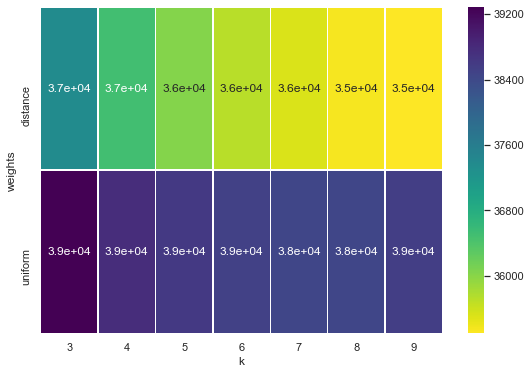

In [16]:
sns.set()
df_heat = df_scores1.drop(columns='rank_test_score').groupby(['weights','k'])
df_heat = df_heat['rmse'].sum().unstack()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_heat, annot=True, linewidths=.5, cmap='viridis_r', ax=ax)

Como nos muestra el heatmap, ponderar por la distancia nos está dando mejores resultados. A su vez, en cuanto al numero de vecinos, probaremos seguir aumentándolo ya que el RMSE óptimo está en la esquina superior derecha.

In [17]:
knr_pipe = Pipeline([('scaler',StandardScaler()),('knr',KNR(weights='distance'))])
k_grid2 = {'knr__n_neighbors':range(9,25),}
grid2 = GridSearchCV(knr_pipe,k_grid2,scoring='neg_mean_squared_error',cv=2)
grid2.fit(X_train,y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='distance'))],
                                verbose=False),
 

In [18]:
df_scores2 = pd.DataFrame(grid2.cv_results_)
df_scores2 = df_scores2[['param_knr__n_neighbors','mean_test_score','rank_test_score']]
df_scores2.rename({'param_knr__n_neighbors':'k'},inplace=True,axis=1)
df_scores2['rmse'] = np.sqrt(-df_scores2['mean_test_score'])
df_scores2.drop(columns='mean_test_score',inplace=True)
df_scores2.sort_values(by='rmse')

,k,rank_test_score,rmse
2,11,1,35168.896654
3,12,2,35179.486079
8,17,3,35182.041632
7,16,4,35183.710609
6,15,5,35183.881486
4,13,6,35184.386122
9,18,7,35205.832548
5,14,8,35207.825539
10,19,9,35222.330683
1,10,10,35230.231852


Veámoslo gráficamente.

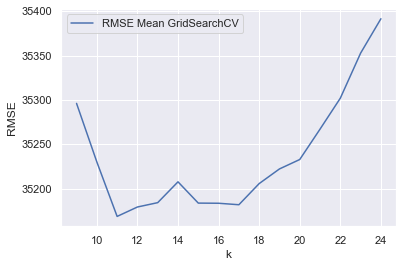

In [19]:
plt.plot(df_scores2.k,df_scores2.rmse,label='RMSE Mean GridSearchCV')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()

Para finalizar, vamos a aumentar el número de k folds alrededor de la zona óptima, de modo tal de reducir el margen de error de este procedimiento.

In [20]:
# Ahora sí, refinamos la búsqueda aumentando el cv
knr_pipe = Pipeline([('scaler',StandardScaler()),('knr',KNR(weights='distance'))])
k_grid3 = {'knr__n_neighbors':range(12,17),}
grid3 = GridSearchCV(knr_pipe,k_grid3,scoring='neg_mean_squared_error',cv=10)
grid3.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='distance'))],
                                verbose=False),


In [21]:
df_scores3 = pd.DataFrame(grid3.cv_results_)
df_scores3 = df_scores3[['param_knr__n_neighbors','mean_test_score','rank_test_score']]
df_scores3.rename({'param_knr__n_neighbors':'k'},inplace=True,axis=1)
df_scores3['rmse'] = np.sqrt(-df_scores3['mean_test_score'])
df_scores3.drop(columns='mean_test_score',inplace=True)
df_scores3.sort_values(by='rmse')

,k,rank_test_score,rmse
2,14,1,31679.685845
3,15,2,31685.903163
1,13,3,31697.442011
4,16,4,31705.419534
0,12,5,31727.729443


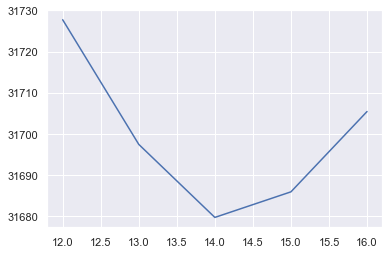

In [22]:
plt.plot(df_scores3.k,df_scores3.rmse)

Del hyperparameter tuning, nos quedamos con n_neighbors = 14 y weights = distance. Este será nuestro segundo modelo, grid3. 

### Optimización de hiperparámetros #2: distancia euclideana ponderada

Distancia euclideana bla, bla, bla

In [23]:
def objective_cv(X,y,weight_list,k=5,cv=10):
    knr_scw = Pipeline([('scaler',StandardScaler()),
                        ('knr',KNR(n_neighbors=k,metric='wminkowski', p=2, 
                         metric_params={'w': weight_list},weights='distance'))])
    scores = np.sqrt(-cross_val_score(knr_scw, X, y, cv=cv,scoring='neg_mean_squared_error'))
    return scores.mean()

In [24]:
dflong,dfshort = train_test_split(df,test_size=0.2,random_state=7)

In [25]:
Xshort = dfshort.drop(columns=['price'])
yshort = dfshort['price']

In [26]:
lista1 = [1446.4561770748116, 547.4659989484442, 140.98813877010545, 5194.8977886395805, 1807.3884473173498, 213.59370469993235,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1]

In [30]:
knr_scw = Pipeline([('scaler',StandardScaler()),
                        ('knr',KNR(metric='wminkowski', p=2, 
                         metric_params={'w': lista1},weights='distance'))])
knrw_params = {'knr__n_neighbors':range(10,35)}
grid_scw = GridSearchCV(knr_scw,knrw_params,cv=2,scoring='neg_mean_squared_error')
grid_scw.fit(Xshort,yshort)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='wminkowski',
                                                            metric_params={'w': [1446.4561770748116,
                                                                                 547.4659989484442,
                                                                                 140.98813877010545,
                                                              

In [33]:
dfver = pd.DataFrame(grid_scw.cv_results_)
dfver.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knr__n_neighbors,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
13,0.050629,1.946568e-03,7.269335,0.048571,23,{'knr__n_neighbors': 23},-1.437854e+09,-1.444585e+09,-1.441219e+09,3.365761e+06,1
7,0.051147,2.464890e-03,7.162199,0.048570,17,{'knr__n_neighbors': 17},-1.429339e+09,-1.453382e+09,-1.441360e+09,1.202149e+07,2
8,0.053108,3.436089e-03,7.090527,0.008716,18,{'knr__n_neighbors': 18},-1.433892e+09,-1.449888e+09,-1.441890e+09,7.998237e+06,3
12,0.049885,1.698613e-03,7.161702,0.020869,22,{'knr__n_neighbors': 22},-1.434483e+09,-1.449332e+09,-1.441908e+09,7.424401e+06,4
10,0.049389,7.065535e-04,7.152792,0.107651,20,{'knr__n_neighbors': 20},-1.438627e+09,-1.446061e+09,-1.442344e+09,3.717040e+06,5
11,0.047923,7.591248e-04,7.231846,0.091515,21,{'knr__n_neighbors': 21},-1.437197e+09,-1.449036e+09,-1.443117e+09,5.919403e+06,6
9,0.051380,2.683997e-03,7.141855,0.081301,19,{'knr__n_neighbors': 19},-1.436275e+09,-1.450825e+09,-1.443550e+09,7.275231e+06,7
14,0.048169,5.122423e-04,7.273293,0.054090,24,{'knr__n_neighbors': 24},-1.437982e+09,-1.449373e+09,-1.443677e+09,5.695480e+06,8
6,0.048186,5.960464e-07,7.146040,0.096472,16,{'knr__n_neighbors': 16},-1.430579e+09,-1.457015e+09,-1.443797e+09,1.321835e+07,9
3,0.052085,4.924536e-04,7.119615,0.115577,13,{'knr__n_neighbors': 13},-1.431713e+09,-1.457680e+09,-1.444696e+09,1.298373e+07,10


In [40]:
knr_scw = Pipeline([('scaler',StandardScaler()),
                        ('knr',KNR(metric='wminkowski', p=2, 
                         metric_params={'w': lista1},weights='distance'))])
knrw_params2 = {'knr__n_neighbors':range(16,23)}
grid_scw2 = GridSearchCV(knr_scw,knrw_params2,cv=10,scoring='neg_mean_squared_error')
grid_scw2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knr',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='wminkowski',
                                                            metric_params={'w': [1446.4561770748116,
                                                                                 547.4659989484442,
                                                                                 140.98813877010545,
                                                             

In [48]:
dfver2 = pd.DataFrame(grid_scw2.cv_results_)
np.sqrt(-dfver2[dfver2.rank_test_score == 1]['mean_test_score'])

6    31467.568876
Name: mean_test_score, dtype: float64

In [51]:
np.sqrt(-dfver[dfver.param_knr__n_neighbors == 14]['mean_test_score'])

4    38085.503664
Name: mean_test_score, dtype: float64

In [46]:
(1-(31467 / 31679))*100

0.6692130433410104

In [ ]:
# Dejar
objective_cv(Xshort,yshort,[1 for i in range(Xshort.shape[1])],k=14,cv=2)

In [ ]:
# Dejar
objective_cv(Xshort,yshort,lista1,k=14,cv=2)

In [ ]:
objective_cv(X_train,y_train,lista1,k=14,cv=10)

In [ ]:
objective_cv(X_train,y_train,[1 for i in range(Xshort.shape[1])],k=14,cv=10)

## Apéndice: exportando información para mapas interactivos

In [88]:
# Sampleo subconjunto de test para mapa interactivo
# Quiero una muestra de tamaño 100 aprox

descarte,sample = train_test_split(df_test,test_size=0.02,random_state=11)
X_sample = sample.drop(columns='price')
y_sample = sample.price
X_sample_scaled = scaler1.transform(X_sample)
X_sample.shape[0]

77

In [85]:
# Exporto datos de muestra para mapa (lat, lon, precio_m2, surface)
string_sample = 'var sampleList = ['
# Uso la referencia de índices del df original
for j in (X_sample.index):
    obj = {}
    lat,lon = X_sample.at[j,'lat'],X_sample.at[j,'lon']
    surface = X_sample.at[j,'surface_total']
    price = df_test.at[j,'price']
    price_m2 = df_test.at[j,'price'] / df_test.at[j,'surface_total']
    obj['muestra'],obj['lat'],obj['lon'],obj['price'] = j,lat,lon,price
    obj['price_m2'],obj['surface'] = round(price_m2,2),surface
    string_sample += str(obj) + ','

string_sample += ']'

with open('samplekNN.txt', 'w') as file:
        file.write(string_sample)

In [93]:
predictions = knr1.predict(X_sample_scaled)
neighbors_ind = knr1.kneighbors(X_sample_scaled)[1]
prediction_string = 'var predictionNaif = ['
for i, j in zip(range(X_sample.shape[0]),X_sample.index):
    obj = {}
    neighbors = df.iloc[neighbors_ind[i],:]
    neighbors['price_m2'] = round(neighbors['price'] / neighbors['surface_total'],2)
    surf_mean = neighbors['surface_total'].mean()
    price_m2_mean = neighbors['price_m2'].mean()
    price_mean = neighbors['price'].mean()
    price_m2_target = df.at[20751,'price'] / df.at[20751,'surface_total']
    obj['neigh_lat_list'] = list(neighbors['lat'])
    obj['neigh_lon_list'] = list(neighbors['lon'])
    obj['neigh_price_m2_list'] = list(neighbors['price_m2'])
    obj['neigh_surf_list'] = list(neighbors['surface_total']) 
    obj['neigh_mean_surf'] = round(surf_mean)
    obj['target_surf'] = df.at[20751,'surface_total']
    obj['neigh_mean_price_m2'] = round(price_m2_mean,2)
    obj['target_price_m2'] = round(price_m2_target,2)
    obj['pred_price'] = predictions[7]
    obj['target_price'] = df.at[20751,'price']
    prediction_string += str(obj) + ','

prediction_string += ']'
with open('predictionKNN1.txt', 'w') as file:
        file.write(prediction_string)

C:\Users\Usuario\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
